In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential


class EmnistModel(Sequential):
    def __init__(self, num_classes):
        super().__init__()        
        self.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28,28,1)))
        self.add(BatchNormalization())
        self.add(Conv2D(32, kernel_size = 3, activation='relu'))
        self.add(BatchNormalization())
        self.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(0.4))

        self.add(Conv2D(64, kernel_size = 3, activation='relu'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, kernel_size = 3, activation='relu'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(0.4))

        self.add(Conv2D(256, kernel_size = 4, activation='relu'))
        self.add(BatchNormalization())
        self.add(Flatten())
        self.add(Dropout(0.4))
        self.add(Dense(num_classes, activation='softmax'))
        
        self.compile(loss='categorical_crossentropy', 
                     #optimizer=tf.keras.optimizers.SGD(lr=0.0001, clipvalue=0.5, momentum=0.9), 
                     optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
                     metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np

def load_emnist(path, num_classes, label_offset=0, verbose=0, limit=0):
    xs = []
    ys = []

    k = 0
    with open(path, 'r') as f:
        for line in f:
            k+=1
            if verbose != 0 and k % 50000==0: print(f"Line {k}")
            x = list(map(int, line.split(",")))
            y = [1 if i == x[0]-label_offset else 0 for i in range(num_classes)]
            x = [v/255.0 for v in x[1:]]
            if(len(x)!=28*28): print(f"Error at {k}")
            xs.append(np.transpose(np.array(x).astype('float32').reshape(28, 28)).reshape(28,28,1))
            ys.append(np.array(y).astype('float32'))    
            if limit>0 and k==limit: break
    return (np.array(xs), np.array(ys))


def load_emnist_labels(path):        
    with open(path, 'r') as f:
        vals = [list(map(int, line.split())) for line in f.readlines()]
    mx = max([v[0] for v in vals])
    mn = min([v[0] for v in vals])
    r = [None]*(mx-mn+1)
    for v in vals:
        r[v[0]-mn] = chr(v[1])
    return r
    

In [3]:
set_name = "letters"
num_classes = 26

In [4]:
labels = load_emnist_labels(f"/kaggle/input/try-emnist-ds/try_emnist_ds/emnist-{set_name}-mapping.txt")
print(labels)

x_train, y_train = load_emnist(f"/kaggle/input/try-emnist-ds/try_emnist_ds/emnist-{set_name}-train.csv", num_classes, label_offset=1, verbose=1)
x_test, y_test = load_emnist(f"/kaggle/input/try-emnist-ds/try_emnist_ds/emnist-{set_name}-test.csv", num_classes, label_offset=1, verbose=1)

print(f"{len(x_train)} {len(y_train)} {len(x_test)} {len(y_test)}")

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Line 50000
88800 88800 14800 14800


In [5]:
print(x_train[0].shape)
print(y_train[0].shape)

(28, 28, 1)
(26,)


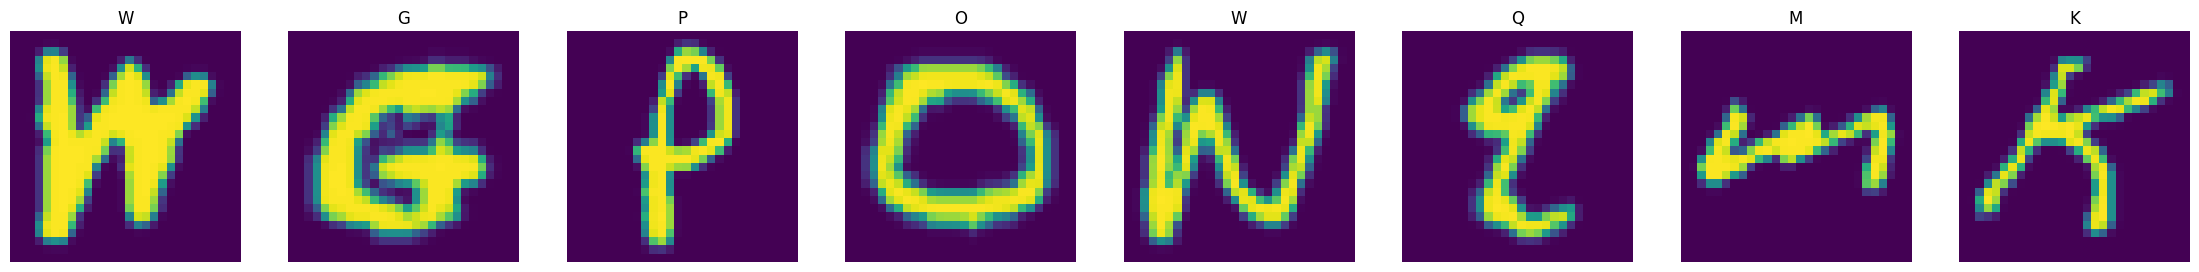

In [6]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(100, 100)) 

for i in range(8):
    fig.add_subplot(28, 28, i+1) 
    plt.axis('off') 
    plt.imshow(x_train[i].reshape((28, 28)))
    plt.title(labels[y_train[i].argmax()])

In [7]:
model = EmnistModel(num_classes)
model.summary()

Model: "emnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_2 (Bat  (None, 12, 12, 32)       

In [8]:
#model.fit(x_train[:10000], y_train[:10000], batch_size=25, epochs=10, verbose=1, 
#          validation_data=(x_test[:50], y_test[:50]), shuffle=True)

In [9]:
history = model.fit(x_train, y_train, batch_size=25, epochs=300, verbose=2, 
          validation_data=(x_test, y_test), shuffle=True)
model.save_weights("weights.h5")

Epoch 1/300


2023-12-04 09:19:11.514883: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inemnist_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3552/3552 - 30s - loss: 0.6537 - accuracy: 0.7978 - val_loss: 0.3291 - val_accuracy: 0.8876 - 30s/epoch - 8ms/step
Epoch 2/300
3552/3552 - 22s - loss: 0.3721 - accuracy: 0.8781 - val_loss: 0.2644 - val_accuracy: 0.9074 - 22s/epoch - 6ms/step
Epoch 3/300
3552/3552 - 22s - loss: 0.3200 - accuracy: 0.8937 - val_loss: 0.2289 - val_accuracy: 0.9200 - 22s/epoch - 6ms/step
Epoch 4/300
3552/3552 - 22s - loss: 0.2923 - accuracy: 0.9035 - val_loss: 0.2343 - val_accuracy: 0.9181 - 22s/epoch - 6ms/step
Epoch 5/300
3552/3552 - 22s - loss: 0.2753 - accuracy: 0.9076 - val_loss: 0.2081 - val_accuracy: 0.9249 - 22s/epoch - 6ms/step
Epoch 6/300
3552/3552 - 21s - loss: 0.2599 - accuracy: 0.9125 - val_loss: 0.2056 - val_accuracy: 0.9238 - 21s/epoch - 6ms/step
Epoch 7/300
3552/3552 - 21s - loss: 0.2510 - accuracy: 0.9153 - val_loss: 0.2153 - val_accuracy: 0.9174 - 21s/epoch - 6ms/step
Epoch 8/300
3552/3552 - 21s - loss: 0.2415 - accuracy: 0.9187 - val_loss: 0.2042 - val_accuracy: 0.9274 - 21s/epoch - 6ms/s

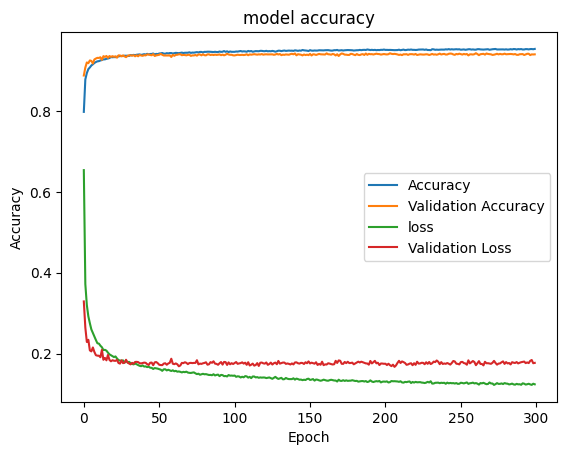

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [12]:
ls -al

total 1884
drwxr-xr-x 3 root root    4096 Dec  4 09:16 ./
drwxr-xr-x 5 root root    4096 Dec  4 08:51 ../
drwxr-xr-x 2 root root    4096 Dec  4 08:51 .virtual_documents/
-rw-r--r-- 1 root root 1916520 Dec  4 11:05 weights.h5


463/463 [==============================] - 1s 2ms/step


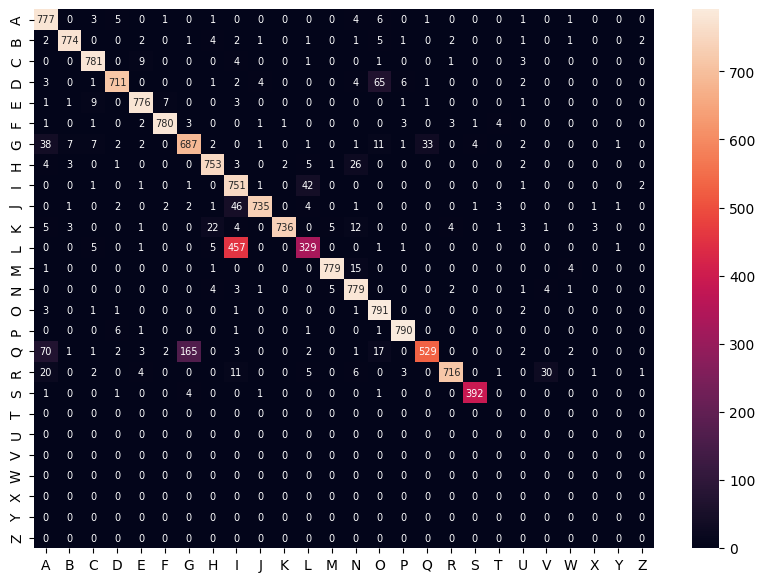

In [23]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from matplotlib import pyplot as plt

y_pred = model.predict(x_test)
y_test_r = np.argmax(y_test, axis=1)
y_pred_r = np.argmax(y_pred, axis=1)

df_cm = pd.DataFrame(tf.math.confusion_matrix(y_test_r, y_pred_r), 
                     index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g',
          annot_kws={"fontsize":7})
plt.show()

2775/2775 [==============================] - 6s 2ms/step


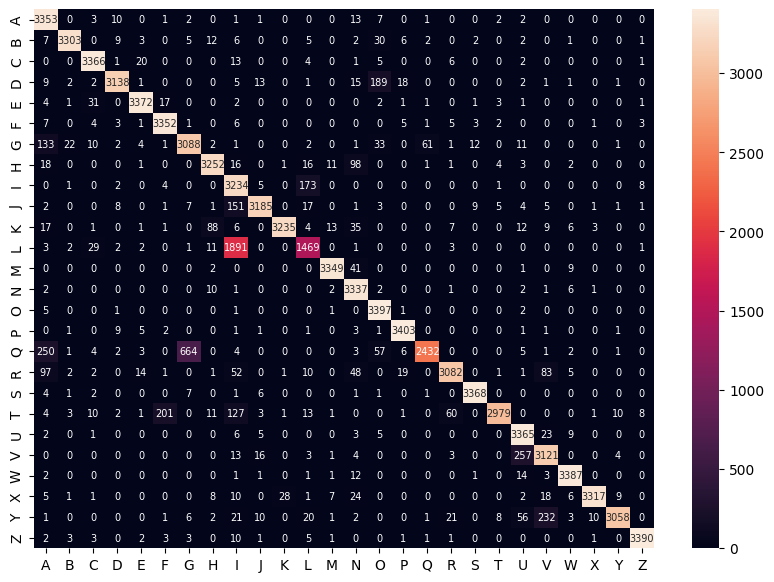

In [22]:
y_pred = model.predict(x_train)
y_train_r = np.argmax(y_train, axis=1)
y_pred_r = np.argmax(y_pred, axis=1)

df_cm = pd.DataFrame(tf.math.confusion_matrix(y_train_r, y_pred_r), 
                     index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g',
          annot_kws={"fontsize":7})
plt.show()